<a href="https://colab.research.google.com/github/leolellisr/npl_natural_language_processing_projects/blob/main/03_Binary_Classifier_Sentiment_Analysis_IMDB/03_Binary_Classifier_Sentiment_Analysis_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de referência 

Nome: Leonardo de Lellis Rossi

## Instruções

- Treinar uma rede neural como classificador binário na tarefa de análise de sentimentos usando dataset IMDB.

- Experimentar e reportar a acurácia usando 3 diferentes tipos de features como entrada:
    1) Bag-of-words booleano
    2) Bag-of-words com contagem das palavras (histograma das palavras)
    3) TF-IDF

Deve-se implementar o laço de treinamento e validação da rede neural.

Neste exercício usaremos o IMDB com 20l exemplos para treino, 5k para desenvolvimento e 25k para teste.

## Preparando Dados

Primeiro, fazemos download do dataset:

In [ ]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz


--2021-09-02 14:01:35--  http://files.fast.ai/data/aclImdb.tgz
Resolving files.fast.ai (files.fast.ai)... 104.26.3.19, 104.26.2.19, 172.67.69.159, ...
Connecting to files.fast.ai (files.fast.ai)|104.26.3.19|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.fast.ai/data/aclImdb.tgz [following]
--2021-09-02 14:01:35--  https://files.fast.ai/data/aclImdb.tgz
Connecting to files.fast.ai (files.fast.ai)|104.26.3.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145982645 (139M) [application/x-gtar-compressed]
Saving to: ‘aclImdb.tgz’

aclImdb.tgz         100%[===================>] 139.22M  40.4MB/s    in 3.6s    

2021-09-02 14:01:38 (38.1 MB/s) - ‘aclImdb.tgz’ saved [145982645/145982645]



## Carregando o dataset

Criaremos uma divisão de treino (80%) e validação (20%) artificialmente.

Nota: Evitar de olhar ao máximo o dataset de teste para não ficar enviseado no que será testado. Em aplicações reais, o dataset de teste só estará disponível no futuro, ou seja, é quando o usuário começa a testar o seu produto.

In [ ]:
import os
import random


def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test = [True] * len(x_test_pos) + [False] * len(x_test_neg)

# Embaralhamos o treino para depois fazermos a divisão treino/valid.
c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

n_train = int(0.8 * len(x_train))

x_valid = x_train[n_train:]
y_valid = y_train[n_train:]
x_train = x_train[:n_train]
y_train = y_train[:n_train]

print(len(x_train), 'amostras de treino.')
print(len(x_valid), 'amostras de desenvolvimento.')
print(len(x_test), 'amostras de teste.')

print('3 primeiras amostras treino:')
for x, y in zip(x_train[:3], y_train[:3]):
    print(y, x[:100])

print('3 últimas amostras treino:')
for x, y in zip(x_train[-3:], y_train[-3:]):
    print(y, x[:100])

print('3 primeiras amostras validação:')
for x, y in zip(x_valid[:3], y_test[:3]):
    print(y, x[:100])

print('3 últimas amostras validação:')
for x, y in zip(x_valid[-3:], y_valid[-3:]):
    print(y, x[:100])

20000 amostras de treino.
5000 amostras de desenvolvimento.
25000 amostras de teste.
3 primeiras amostras treino:
False Without a doubt this is one of the worst films I've ever wasted money on! The plot is, erm sorry, di
False "Proximity" tells of a convict (Lowe) who thinks the prison staff is out to kill him. This very ordi
True A serious comedy. Ross Hunter-produced movie version of the French play "Les Joies de la famille" (l
3 últimas amostras treino:
False Okay at first this movie seemed pretty good even though it was moving rather quick and even though t
False Tashan - the title itself explains the nature of the movie.<br /><br />This type of movies are actua
True Now I had the pleasure of first viewing Contaminated Man when it premiered on TV back in December of
3 primeiras amostras validação:
True As the 2000's came to a close, king Kong's adopted daughter went ahead and made a tearful announceme
True Excellent film. Suzy Kendall will hold your interest throughout. Has not bee

Imports

In [ ]:
%matplotlib inline
import numpy as np
from bs4 import BeautifulSoup
import torch
from torch.utils.data import DataLoader

import re
from collections import Counter
import numpy as np

from torchtext.vocab import vocab
import matplotlib.pyplot as plt


In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
   print(torch. cuda. get_device_name(dev))
else: 
   dev = "cpu" 
print(dev)
device = torch.device(dev)

Tesla K80
cuda:0


# Tokenizer function

In [ ]:
def tokenizer(sentence):
    #Beautiful soup to remove tags of sentences 
    removeTags = BeautifulSoup(sentence, 'html.parser') 

    # Getting list of words and remove numbers and ponctuation with regex
    removeNotWords = re.sub('\W+',' ', removeTags.text)
    regex = re.compile('\w+|[^\w\s]+')
    re_split = regex.findall(removeNotWords.lower())
    
    re_split_without_numbers = [word for word in re_split if not word.isnumeric()]
    return re_split_without_numbers
x_train_token = tokenizer(' '.join(x_train))

Vocabulário

uso de "vocab" => Ref: Vitor Jeronimo

In [ ]:
# Count tokens
counterTokens = Counter(x_train_token)

# Define vocabulary with torch.vocab
vocab_train = vocab(counterTokens, min_freq=1)
vocab_train.set_default_index(len(vocab_train))

print('len of train vocabulary is',len(counterTokens))

bow_pipeline = lambda x: [vocab_train[token] for token in tokenizer(x)]

len of train vocabulary is 68552


# IDF function

In [ ]:
# Get tokens per document
train_tokens = [list(set(bow_pipeline(i))) for i in x_train] 

# idf calculus
idf = torch.zeros(len(vocab_train)+1).long()
for index in train_tokens:
    idf[index] += 1
idf = torch.log10(len(x_train)/idf)

# Define unknown token to -1
idf[-1] = 1        

# Dataset class

In [ ]:
class Ex3_ds(torch.utils.data.Dataset):

    def __init__(self, x, y, mode):
        self.x = x
        self.y = y
        self.mode = mode

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        all_tokens = torch.zeros(len(vocab_train)+1) 
        y_label = int(self.y[index]) # bool to int
        if self.mode == 'bow':
            all_tokens[bow_pipeline(self.x[index])] = 1
        elif self.mode in ['bow_hist', 'tf_idf']:
            all_tokens = all_tokens.long()
            count_dict = Counter(bow_pipeline(self.x[index]))
            dict_keys = list(count_dict.keys())
            dict_values = torch.tensor(list(count_dict.values())).long()
            all_tokens[dict_keys] = dict_values
            all_tokens = all_tokens.float()
            if self.mode == 'tf_idf':
                all_tokens *= idf
        return all_tokens, y_label

# Model class

In [ ]:
class Ex3_model(torch.nn.Module):
    def __init__(self, input, hidden):
        super(Ex3_model, self).__init__()
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(input, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, 2),
        )
    
    def forward(self, x):
        x = self.dense(x)
        return x

# Input size: vocab_train+1 (unknown)
# Hidden size: 128

ex3_model = Ex3_model(len(vocab_train)+1, 128)
ex3_model.to(device)

# Summary
print(ex3_model)

Ex3_model(
  (dense): Sequential(
    (0): Linear(in_features=68553, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


# Train parameters

loss function: CrossEntropy

In [ ]:
n_epochs = 10
learningRate = 0.0001

# CrossEntropyLoss as loss function
criterion = torch.nn.CrossEntropyLoss()

# Train loop function

In [ ]:


def train_loop(dataloader_train, dataloader_val, hyperparameters):
    epoch_arr = []
    train_loss_arr = []
    val_loss_arr = []
    acc_arr = []
    
    # Gradient descent
    optimizer = torch.optim.Adam(ex3_model.parameters(), lr=hyperparameters['learning_rate'])
    min_val_loss = 10e9
    best_epoch = 0
    for epoch in range(hyperparameters['n_epochs']):
      epoch_arr.append(epoch)
      total_loss = 0
      ex3_model.train()
      for x_train, y_train in dataloader_train:
            # transform to one dimention
        x_train = x_train.to(device)
        y_train = y_train.to(device)
            
            # predict 
        outputs = ex3_model(x_train)

            # batch loss
        batch_loss = criterion(outputs, y_train)

            # reset gradients, backpropagation, optimizer step and sum loss
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
            #print(f'{hyperparameters["model_name"]}_train/batch_loss: {batch_loss}')

      train_loss = total_loss / len(dataloader_train.dataset)
        #print(f'Epoch {epoch} / {hyperparameters["model_name"]} train loss: {train_loss}')
      train_loss_arr.append(train_loss)
        # Validation (end of epoch).
      total_loss = 0
      total_acc = 0
      ex3_model.eval()
      with torch.no_grad():
        for x_val, y_val in dataloader_val:
          x_val = x_val.to(device)
          y_val = y_val.to(device)

                # predict
          outputs = ex3_model(x_val)

                # batch loss
          batch_loss = criterion(outputs, y_val)
          preds = outputs.argmax(dim=1)

                # val acc
          batch_acc = (preds == y_val).sum()
          total_loss += batch_loss
          total_acc += batch_acc

      val_loss = total_loss / len(dataloader_val.dataset)
      val_loss_arr.append(val_loss)

        #print(f'Epoch {epoch} / {hyperparameters["model_name"]} val loss: {val_loss}')
      acc_arr.append(total_acc / len(dataloader_val.dataset))

        #print(f'Epoch {epoch} / {hyperparameters["model_name"]} val acc: {total_acc / len(dataloader_val.dataset)}')
        #print(total_acc / len(dataloader_val.dataset))

      print(f'Epoch: {epoch+1}/{hyperparameters["n_epochs"]} - train_loss: {train_loss} - val_loss: {val_loss} - acc: {total_acc / len(dataloader_val.dataset)*100} %')

        # Save best model
      if val_loss < min_val_loss:
        torch.save(ex3_model.state_dict(), 'best_model.pt')
        min_val_loss = val_loss
        best_epoch = epoch
        print(f'best model in epoch: {best_epoch+1}')


    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    ax1.plot(epoch_arr, train_loss_arr)
    ax1.set_title('Train Loss')

    ax2.plot(epoch_arr, val_loss_arr)
    ax2.set_title('Val Loss')

    ax3.plot(epoch_arr, acc_arr)
    ax3.set_title('Val Acc')

In [ ]:
# Function to test acc
def predict(model, inputs):
    outputs = model(inputs)
    _, predicts = torch.max(outputs, 1)
    return predicts

# **Bag of Words** (BoW) train

Batch size: 50 => Acc: 86,7%

Batch size: 20 => Acc: 86,7%

Tempo de execução por epoch: +-25s

Tempo total de execução: 4m16s


Epoch: 1/10 - train_loss: 0.009110543907433748 - val_loss: 0.006380694918334484 - acc: 88.0 %
best model in epoch: 1
Epoch: 2/10 - train_loss: 0.004503565760701895 - val_loss: 0.005418634507805109 - acc: 88.94000244140625 %
best model in epoch: 2
Epoch: 3/10 - train_loss: 0.002925759535096586 - val_loss: 0.005305474624037743 - acc: 89.12000274658203 %
best model in epoch: 3
Epoch: 4/10 - train_loss: 0.002005275175347924 - val_loss: 0.005495659541338682 - acc: 89.12000274658203 %
Epoch: 5/10 - train_loss: 0.0013990178061649204 - val_loss: 0.005748307798057795 - acc: 88.79999542236328 %
Epoch: 6/10 - train_loss: 0.000985942146461457 - val_loss: 0.00618847506120801 - acc: 88.5999984741211 %
Epoch: 7/10 - train_loss: 0.0006989670445676893 - val_loss: 0.00653647119179368 - acc: 88.23999786376953 %
Epoch: 8/10 - train_loss: 0.000492398256668821 - val_loss: 0.00693887984380126 - acc: 87.95999908447266 %
Epoch: 9/10 - train_loss: 0.00035185441754292696 - val_loss: 0.007391610648483038 - acc: 8

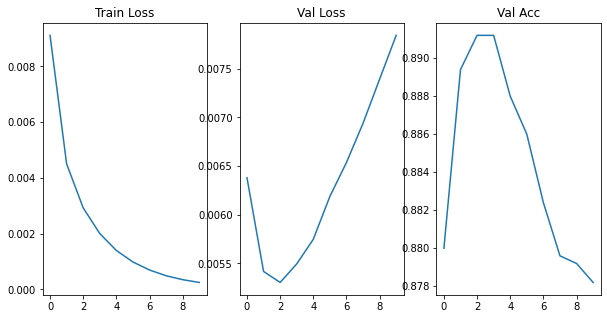

In [ ]:
hyperparameters = { "mode": "bow",
          "learning_rate": 1e-4,
          "n_epochs": 10,
          "batch_size": 50,
          "hidden_size": 128 }
train_ds = Ex3_ds(x_train, y_train, hyperparameters['mode'])
val_ds = Ex3_ds(x_valid, y_valid, hyperparameters['mode'])
dataloader_train = DataLoader(train_ds, batch_size=hyperparameters['batch_size'], shuffle=True)
dataloader_val = DataLoader(val_ds, batch_size=hyperparameters['batch_size'], shuffle=False)       
train_loop(dataloader_train, dataloader_val, hyperparameters)   

In [ ]:
del train_ds
del val_ds
del dataloader_train
del dataloader_val

## Acc BoW

In [ ]:
test_ds = Ex3_ds(x_test, y_test, hyperparameters['mode'])
dataloader_test = DataLoader(test_ds, batch_size=hyperparameters['batch_size'], shuffle=False)  
total_acc = 0     
with torch.no_grad():
  for x_t, y_t in dataloader_test:
    x_t = x_t.to(device)
    #print(x_t.shape)
    y_t = y_t.to(device)
    #print(y_t.shape)
    outputs = ex3_model(x_t)
    #print(outputs.shape)

    #preds = outputs > 0.5

    preds = outputs.argmax(dim=1)
    #print(preds.shape)

    # test acc
    batch_acc = (preds == y_t).sum()
    total_acc += batch_acc
  test_acc = total_acc / len(dataloader_test.dataset)
  print(f"BoW Acc: {test_acc*100} %")    

BoW Acc: 86.38800048828125 %


# **Bag of Words** Hist train

Tempo de execução por epoch: +-30s

Tempo total de execução: 5m10s

Epoch: 1/10 - train_loss: 0.0006612523182702717 - val_loss: 0.010178453288972378 - acc: 87.75999450683594 %
best model in epoch: 1
Epoch: 2/10 - train_loss: 0.00020636112145730294 - val_loss: 0.01000647060573101 - acc: 88.15999603271484 %
best model in epoch: 2
Epoch: 3/10 - train_loss: 0.00013160883167875 - val_loss: 0.010267583653330803 - acc: 87.86000061035156 %
Epoch: 4/10 - train_loss: 0.00010000620251812506 - val_loss: 0.01051186304539442 - acc: 87.93999481201172 %
Epoch: 5/10 - train_loss: 7.718072396091885e-05 - val_loss: 0.010840805247426033 - acc: 87.75999450683594 %
Epoch: 6/10 - train_loss: 6.10444214893505e-05 - val_loss: 0.01116544846445322 - acc: 87.63999938964844 %
Epoch: 7/10 - train_loss: 4.868716074852273e-05 - val_loss: 0.01149753388017416 - acc: 87.69999694824219 %
Epoch: 8/10 - train_loss: 3.901448382384842e-05 - val_loss: 0.011961431242525578 - acc: 87.72000122070312 %
Epoch: 9/10 - train_loss: 3.149863506332622e-05 - val_loss: 0.012428855523467064 - acc: 87.6599

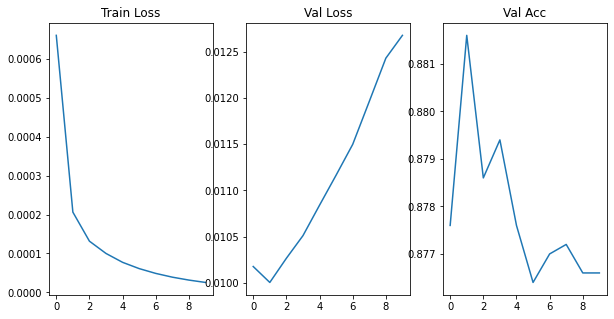

In [ ]:
hyperparameters = { "mode": "bow_hist",
          "learning_rate": 1e-4,
          "n_epochs": 10,
          "batch_size": 50,
          "hidden_size": 128 }
train_ds = Ex3_ds(x_train, y_train, hyperparameters['mode'])
val_ds = Ex3_ds(x_valid, y_valid, hyperparameters['mode'])
dataloader_train = DataLoader(train_ds, batch_size=hyperparameters['batch_size'], shuffle=True)
dataloader_val = DataLoader(val_ds, batch_size=hyperparameters['batch_size'], shuffle=False)       
train_loop(dataloader_train, dataloader_val, hyperparameters)   

In [ ]:
del train_ds
del val_ds
del dataloader_train
del dataloader_val

## Acc BoW Hist

In [ ]:
test_ds = Ex3_ds(x_test, y_test, hyperparameters['mode'])
dataloader_test = DataLoader(test_ds, batch_size=hyperparameters['batch_size'], shuffle=False)  
total_acc = 0     
with torch.no_grad():
  for x_t, y_t in dataloader_test:
    x_t = x_t.to(device)
    #print(x_t.shape)
    y_t = y_t.to(device)
    #print(y_t.shape)
    outputs = ex3_model(x_t)
    #print(outputs.shape)

    #preds = outputs > 0.5

    preds = outputs.argmax(dim=1)
    #print(preds.shape)

    # test acc
    batch_acc = (preds == y_t).sum()
    total_acc += batch_acc
  test_acc = total_acc / len(dataloader_test.dataset)

  print(f"BoW Hist Acc: {test_acc*100} %")    

BoW Hist Acc: 83.7439956665039 %


# **TF_IDF** train

Tempo de execução por epoch: +-33s

Tempo total de execução: 5m39s

Epoch: 1/10 - train_loss: 5.2477814460220884e-05 - val_loss: 0.027772966772317886 - acc: 86.0199966430664 %
best model in epoch: 1
Epoch: 2/10 - train_loss: 2.4054328877461728e-06 - val_loss: 0.028327157720923424 - acc: 86.0999984741211 %
Epoch: 3/10 - train_loss: 1.83520006729907e-06 - val_loss: 0.028734758496284485 - acc: 86.05999755859375 %
Epoch: 4/10 - train_loss: 1.5097638948223136e-06 - val_loss: 0.029067525640130043 - acc: 86.07999420166016 %
Epoch: 5/10 - train_loss: 1.2816320709664098e-06 - val_loss: 0.029362820088863373 - acc: 86.05999755859375 %
Epoch: 6/10 - train_loss: 1.1113112073111609e-06 - val_loss: 0.02963375858962536 - acc: 86.03999328613281 %
Epoch: 7/10 - train_loss: 9.714998451144652e-07 - val_loss: 0.029892360791563988 - acc: 86.03999328613281 %
Epoch: 8/10 - train_loss: 8.592494638259396e-07 - val_loss: 0.030131038278341293 - acc: 86.0199966430664 %
Epoch: 9/10 - train_loss: 7.647753384890876e-07 - val_loss: 0.03037092462182045 - acc: 85.95999908447266 %
Epoch:

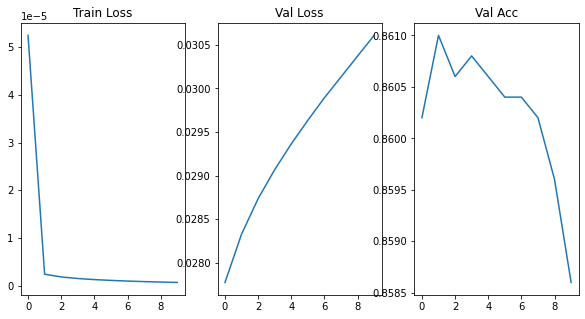

In [ ]:
hyperparameters = { "mode": "tf_idf",
          "learning_rate": 1e-4,
          "n_epochs": 10,
          "batch_size": 50,
          "hidden_size": 128 }
train_ds = Ex3_ds(x_train, y_train, hyperparameters['mode'])
val_ds = Ex3_ds(x_valid, y_valid, hyperparameters['mode'])
dataloader_train = DataLoader(train_ds, batch_size=hyperparameters['batch_size'], shuffle=True)
dataloader_val = DataLoader(val_ds, batch_size=hyperparameters['batch_size'], shuffle=False)       
train_loop(dataloader_train, dataloader_val, hyperparameters)  

In [ ]:
del train_ds
del val_ds
del dataloader_train
del dataloader_val

## Acc TF_IDF

In [ ]:
test_ds = Ex3_ds(x_test, y_test, hyperparameters['mode'])
dataloader_test = DataLoader(test_ds, batch_size=hyperparameters['batch_size'], shuffle=False)  
total_acc = 0     
with torch.no_grad():
  for x_t, y_t in dataloader_test:
    x_t = x_t.to(device)
    #print(x_t.shape)
    y_t = y_t.to(device)
    #print(y_t.shape)
    outputs = ex3_model(x_t)
    #print(outputs.shape)

    #preds = outputs > 0.5

    preds = outputs.argmax(dim=1)
    #print(preds.shape)

    # test acc
    batch_acc = (preds == y_t).sum()
    total_acc += batch_acc
  test_acc = total_acc / len(dataloader_test.dataset)

  print(f"TF_IDF Acc: {test_acc*100} %")    

TF_IDF Acc: 80.35599517822266 %
